<a href="https://colab.research.google.com/github/duanasq/learning-ds-public/blob/main/dl-fundamentals/residual_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Understand Residual Nets 

Generate a training set of periodic functions with different periods (e.g. sin(x), sin(2x) etc). Evaluate them on a regular grid (size n=1024). Input these into a FC neural network, and use the frequency as a label. Compare your results with a deep residual network.

In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.animation as animation

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Step 1. Generate training and test data

The first challenge was understanding what a single sample of data would look like. We decided a single sample would be a vector of length 1024 where each component was `sin(x)` or `sin(kx)` where `x` is between `-10*pi` and `10*pi` and k is the frequency which we will vary. Well, it's not technically the frequency as per the physics definition. To keep things simple, it is the parameter we want the neural net to learn.

TODO: How could we add noise to the data?

In [4]:
def dataset_generate(num_samples):
  size_image = 1024
  # we distinguish btw X and Y vs x and y: 
  # X is the collection of our data samples
  # Y is the collection of the corresponding labels
  # x is used to generate our sin values
  # y is the generated sin value
  X = []
  Y = []
  for i in range(num_samples):
    k = np.random.uniform(low = 0.1, high = 11) # this is the parameter we want to vary and get the NN to learn
    a = 1 #np.random.randn() # this is the amplitude - we will fix this now, but we could vary this in future too
    b = 0 #np.random.randn() # this is the y intercept. ditto
    x = np.linspace(-10*np.pi, 10 * np.pi, size_image) 
    y = a*np.sin(k*x) + b
    X.append(y)
    Y.append(k)
  return np.array(X), np.array(Y)


In [5]:
train_X, train_Y = dataset_generate(1000)
test_X, test_Y = dataset_generate(100)

(1000, 1024)
[ 0.71430984  0.73856101  0.76189218 ... -0.76189218 -0.73856101
 -0.71430984]
0.574674074265798


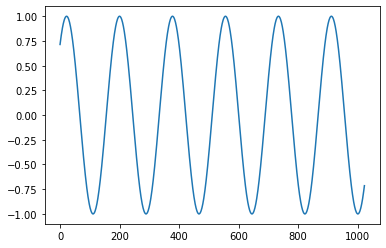

[ 0.18768562  0.5696557   0.85386609 ... -0.85386609 -0.5696557
 -0.18768562]
6.7939901386731165


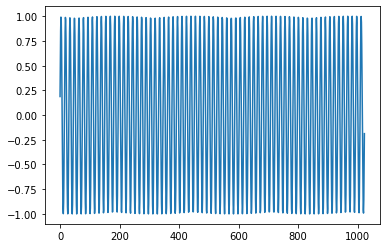

[-0.95869192 -0.79032849 -0.51441269 ...  0.51441269  0.79032849
  0.95869192]
6.040819019131368


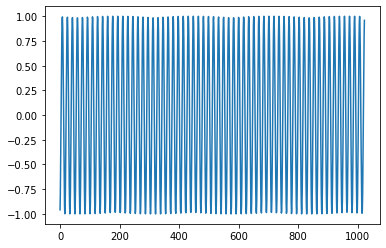

[-0.82602986 -0.48235453 -0.03464733 ...  0.03464733  0.48235453
  0.82602986]
7.6309405794133465


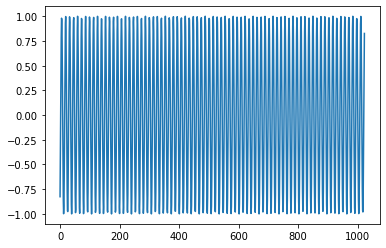

[ 0.64266543  0.56833335  0.48903707 ... -0.48903707 -0.56833335
 -0.64266543]
1.5222171458988352


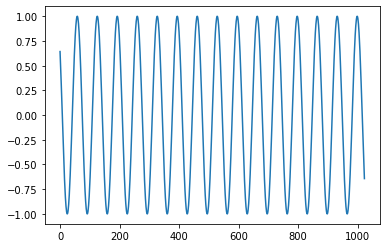

In [6]:
print(train_X.shape)

def display_samples(data, labels, num):
  for i in range(num):
    print(data[i])
    print(labels[i])
    plt.plot(data[i])
    plt.show()

display_samples(train_X, train_Y, 5)

## Step 2. Load data so it can be fed to model

In [7]:
# We have to first load them into Tensors. Tensors track the computations on the underlying multidimensional arrays 
train_tensor_x = torch.Tensor(train_X)
train_tensor_y = torch.Tensor(train_Y)
test_tensor_x = torch.Tensor(test_X)
test_tensor_y = torch.Tensor(test_Y)

In [8]:
# Now we load the Tensors into Datasets which is an abstraction that can hold samples and their labels
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)

# Now we load the datasets into DataLoaders which is an abstraction to feed batches of data to the model
train_dataloader = DataLoader(train_dataset, batch_size=10)
test_dataloader = DataLoader(test_dataset, batch_size=10)

print("num training batches:\t", len(train_dataloader))
print("num training samples per batch:\t", len(train_dataloader.dataset))

num training batches:	 100
num training samples per batch:	 1000


## Step 3. Define a model

We will start with a model with a number of fully-connected layers. The frequency is a continuous variable so this is a regression problem rather than a classification.

In [27]:
def make_model():
  return nn.Sequential(nn.Linear(1024, 1024), nn.Tanh(), nn.Linear(1024, 1024), nn.Tanh(), nn.Linear(1024, 1))

In [33]:
# trains the neural net on one pass of the data
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # from the doco "This has effect only on certain modules. See documentations of particular modules for details of their behaviors in 
    # training/evaluation mode, if they are affected, e.g. Dropout, BatchNorm, etc.
    # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train
    model.train()

    train_loss = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # move tensors to the GPU (if one was available)
        X, y = X.to(device), y.to(device)

        # Compute predictions and then the loss (error) between the predictions and the actuals (labels). 
        # Since the input is tensors, these computations will be tracked by the tensor autograd framework.
        pred = model(X)
        loss = loss_fn(pred, y)

        # reset the weights-and-biases gradients to zero for every new batch 
        # otherwise the calculations accumulate btw batches and the gradients will be wrong
        optimizer.zero_grad()
        # force the calculation of the gradients on the weights-and-biases tensors
        loss.backward()
        # update the weights-and-biases to be a step in the opposite direction of their gradients
        optimizer.step()
        # add up the loss across batches
        train_loss += loss.item()

        if batch_num % 10 == 0:
            loss = loss.item()
            print(f"batch loss: {loss:>7f}, batch [{batch_num:>5d}/{len(dataloader):>5d}]")
    return train_loss / len(dataloader.dataset)

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader) 
    # again some magic here that might not be relevant depending on the model
    model.eval()
    test_loss, correct, relative_error = 0, 0, 0
    # don't track computations for calculating gradients as we aren't optimizing the model
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # add up the loss across batches
            test_loss += loss_fn(pred, y).item()

            # calculate the relative error of each prediction 
            relative_error_temp = abs(y - pred) / abs(y)
            # sum them up
            relative_error +=  relative_error_temp.type(torch.float).sum().item()
    # calculate the mean loss for a sample??
    test_loss /= size
    # calculate the mean relative error (we could also use RMSE)
    relative_error /= size
    return test_loss


In [13]:
def plot_model(model):
  arr = np.linspace(0, 1, num=500)[:, np.newaxis]
  x = torch.Tensor(arr)
  y = model(x).detach()
 # poly = np.poly1d([1, -28, 322, -1960, 6769, -13132, 13068, -540])
  y_real =  3* x[:,0] - 7#poly(arr)#5*x[:,0]**5 + 4*x[:,0]**4 + 3*x[:,0]**3 + 2*x[:,0]**2 + x[:,0] + 42 #3 * x[:,0] - 7
  #print('plotmodel')
  #print(x,y)
  df = pd.DataFrame(data = {"x": x[:, 0], "y": y[:, 0], "y_real": y_real}).melt(id_vars='x', value_vars=['y', 'y_real'])
  #print(df.head())
  sns.scatterplot(data = df, x='x', y='value', hue='variable')
  plt.show()


In [14]:
arr = np.linspace(0, 1, num=500)

In [36]:

def run_model(model):
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
  print(model)

  epochs = 1
  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      train(train_dataloader, model, loss_fn, optimizer)
      test(test_dataloader, model, loss_fn)
  print("Done!")

In [29]:
fully_connected_model = make_model()
#list(my_model.named_parameters())

In [37]:
run_model(fully_connected_model)

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1024, out_features=1, bias=True)
)
batch loss: 10.872149, batch [    0/  100]
batch loss: 11.305996, batch [   10/  100]
batch loss: 10.282014, batch [   20/  100]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch loss: 10.393661, batch [   30/  100]
batch loss: 13.864695, batch [   40/  100]
batch loss: 8.769534, batch [   50/  100]
batch loss: 8.790875, batch [   60/  100]
batch loss: 9.803226, batch [   70/  100]
batch loss: 9.824558, batch [   80/  100]
batch loss: 10.453026, batch [   90/  100]
Done!


In [38]:
plot_model(fully_connected_model)

RuntimeError: ignored